By the end of this week, you will:
- Understand the motivations behind advanced GNN models
- Implement GAT, GraphSAGE, and GIN using PyTorch Geometric
- Train and evaluate them on the Cora dataset
- Compare performance and visualize learned embeddings

# 1. Recap — Why Go Beyond GCN?
| Problem with GCN                            | Solution Model                              |
| ------------------------------------------- | ------------------------------------------- |
| Treats all neighbors equally                | **GAT** — uses attention to weigh neighbors |
| Requires full-graph training (not scalable) | **GraphSAGE** — samples neighbors           |
| Limited expressive power                    | **GIN** — injects MLP expressiveness        |


# 2. Dataset Setup (Cora Again)

In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F

dataset = Planetoid(root="data/Planetoid", name="Cora")
data = dataset[0]


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Graph Attention Network (GAT)

Idea:

Each node attends differently to its neighbors.
Attention coefficients $α_{ij}$

 determine the importance of neighbor j to node i.

In [2]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [3]:
model = GAT(dataset.num_features, 8, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = out.argmax(dim=1)
acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / int(data.test_mask.sum())
print(f"GAT Accuracy: {acc:.4f}")


GAT Accuracy: 0.6290


# 4. GraphSAGE (Inductive Learning)

Idea:

Instead of full adjacency aggregation, sample a fixed number of neighbors.
Supports inductive tasks (new unseen nodes).

In [9]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [10]:
model = GraphSAGE(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = out.argmax(dim=1)
acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / int(data.test_mask.sum())
print(f"GraphSAGE Accuracy: {acc:.4f}")


GraphSAGE Accuracy: 0.7400


# 5. Graph Isomorphism Network (GIN)

Idea:

Aims to be as powerful as the Weisfeiler-Lehman (WL) test for graph isomorphism.
Uses sum aggregation + MLP for expressive updates.

In [11]:
from torch_geometric.nn import GINConv
from torch.nn import Linear, Sequential, ReLU

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = Sequential(Linear(in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)

        nn2 = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, out_channels))
        self.conv2 = GINConv(nn2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [12]:
model = GIN(dataset.num_features, 32, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = out.argmax(dim=1)
acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / int(data.test_mask.sum())
print(f"GIN Accuracy: {acc:.4f}")


GIN Accuracy: 0.7390


# 6. Compare Models

| Model     | Aggregation        | Key Feature                   | Typical Accuracy (Cora) |
| --------- | ------------------ | ----------------------------- | ----------------------- |
| GCN       | Mean               | Spectral Conv                 | ~80%                    |
| GAT       | Attention-weighted | Learnable neighbor importance | ~60%                    |
| GraphSAGE | Mean/Max/Sum       | Inductive sampling            | ~74%                    |
| GIN       | Sum + MLP          | High expressiveness           | ~73%                    |


# Exercises

## EX1: Try Different Aggregations in GraphSAGE



In [5]:
## Try Different Aggregations in GraphSAGE

#Replace:

#SAGEConv(in_channels, hidden_channels, aggr="max")

#Compare "mean", "max", "sum" aggregations.

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv  # <-- Import SAGEConv
import torch.optim as optim


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 dropout_rate, aggr_type):
        super().__init__()
        
        # We pass the aggregation type directly to the SAGEConv layers
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=aggr_type)
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr=aggr_type)
        
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x) # Using ReLU as a standard activation
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    

    

In [7]:
# Setup: Load Data and Device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

# Train and Test Functions (Unchanged from before) 
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(correct) / int(data.val_mask.sum())
    return val_acc

# Best Hyperparameters from Grid Search 
HIDDEN_CHANNELS = 64
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.5
EPOCHS = 200

# The Experiment 
aggregations_to_test = ["mean", "max", "sum"]
results = {}

for aggr in aggregations_to_test:
    print(f"\n--- Training GraphSAGE (aggr='{aggr}') ---")
    
    # Initialize the model with the current aggregation
    model = GraphSAGE(
        in_channels=dataset.num_features,
        hidden_channels=HIDDEN_CHANNELS,
        out_channels=dataset.num_classes,
        dropout_rate=DROPOUT_RATE,
        aggr_type=aggr
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_val_acc = 0
    for epoch in range(1, EPOCHS + 1):
        train(model, optimizer, data)
        val_acc = test(model, data)
        best_val_acc = max(best_val_acc, val_acc)

    print(f"Result: Best Validation Accuracy = {best_val_acc:.4f}")
    results[aggr] = best_val_acc

# 3. Final Comparison 
print("\n--- Final Aggregation Results ---")
for aggr, acc in results.items():
    print(f"GraphSAGE (aggr='{aggr}'): {acc:.4f}")


--- Training GraphSAGE (aggr='mean') ---
Result: Best Validation Accuracy = 0.7860

--- Training GraphSAGE (aggr='max') ---
Result: Best Validation Accuracy = 0.7600

--- Training GraphSAGE (aggr='sum') ---
Result: Best Validation Accuracy = 0.7780

--- Final Aggregation Results ---
GraphSAGE (aggr='mean'): 0.7860
GraphSAGE (aggr='max'): 0.7600
GraphSAGE (aggr='sum'): 0.7780


# EX2 Exercise 2 — Attention Heads in GAT



In [ ]:

#Try:
##model = GAT(dataset.num_features, 8, dataset.num_classes, heads=4)
##Then heads=8, heads=16.
#Measure how multi-head attention changes performance.

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import torch.optim as optim

# --- Model Definition ---

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 heads, dropout_rate):
        super().__init__()
        
        # Layer 1: Multi-head attention. Output dim is hidden_channels * heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        
        # Layer 2: Input dim must match conv1's output.
        # We use heads=1 for the final layer (or averaging).
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout_rate)
        
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        # GAT paper applies dropout to the attention coefficients
        # which is handled by the GATConv layer's dropout param.
        
        x = self.conv1(x, edge_index)
        x = F.elu(x) # GAT uses ELU activation
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [9]:
# --- Setup: Load Data and Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

# --- Train and Test Functions (Unchanged) ---
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(correct) / int(data.val_mask.sum())
    return val_acc

# --- GAT Hyperparameters (from original paper) ---
HIDDEN_CHANNELS = 8 # As you specified
LEARNING_RATE = 0.005
DROPOUT_RATE = 0.6  # GAT uses a higher dropout
WEIGHT_DECAY = 5e-4 # L2 regularization
EPOCHS = 200

# --- The Experiment ---
heads_to_test = [4, 8, 16]
results = {}

for h in heads_to_test:
    print(f"\n--- Training GAT (hidden=8, heads={h}) ---")
    
    # Initialize the model with the current number of heads
    model = GATModel(
        in_channels=dataset.num_features,
        hidden_channels=HIDDEN_CHANNELS,
        out_channels=dataset.num_classes,
        heads=h,
        dropout_rate=DROPOUT_RATE
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    best_val_acc = 0
    for epoch in range(1, EPOCHS + 1):
        train(model, optimizer, data)
        val_acc = test(model, data)
        best_val_acc = max(best_val_acc, val_acc)

    print(f"Result: Best Validation Accuracy = {best_val_acc:.4f}")
    results[f"heads={h}"] = best_val_acc

# --- 3. Final Comparison 
print("\n--- Final Attention Head Results ---")
for config, acc in results.items():
    print(f"GAT (hidden=8, {config}): {acc:.4f}")


--- Training GAT (hidden=8, heads=4) ---
Result: Best Validation Accuracy = 0.7960

--- Training GAT (hidden=8, heads=8) ---
Result: Best Validation Accuracy = 0.7760

--- Training GAT (hidden=8, heads=16) ---
Result: Best Validation Accuracy = 0.7940

--- Final Attention Head Results ---
GAT (hidden=8, heads=4): 0.7960
GAT (hidden=8, heads=8): 0.7760
GAT (hidden=8, heads=16): 0.7940


## Exercise 3 — Embedding Visualization

In [14]:
# Use t-SNE again:

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# 
# z = model.conv1(data.x, data.edge_index).detach()
# z_2d = TSNE(n_components=2).fit_transform(z)
# plt.scatter(z_2d[:,0], z_2d[:,1], c=data.y, cmap='tab10', s=15)
# plt.title("Node Embeddings Visualization")
# plt.show()

Training model to get embeddings...
Model trained. Generating t-SNE plot...


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


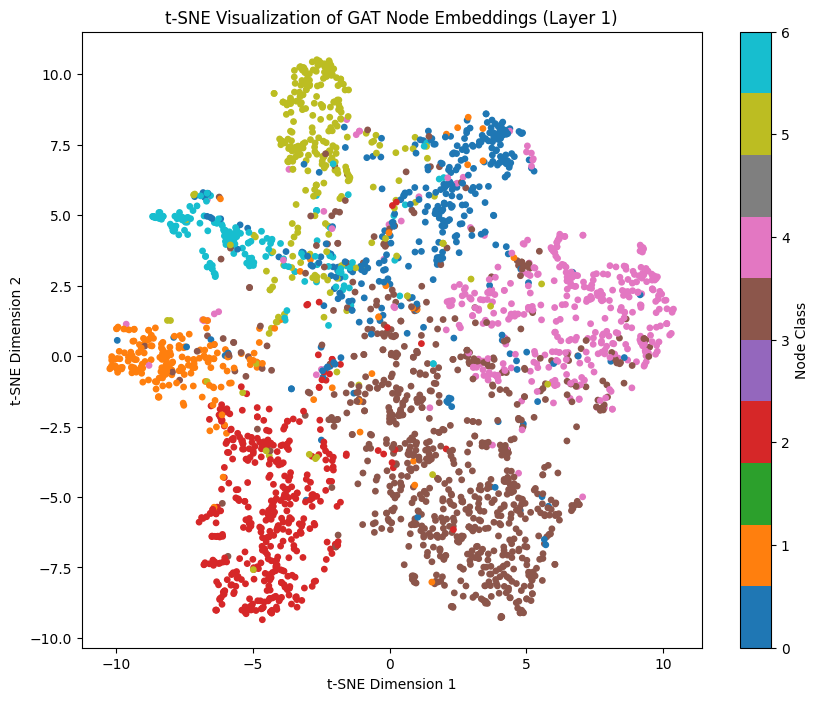

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- 1. Model Definition (GAT) ---
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout_rate):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout_rate)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# --- 2. Setup: Load Data and Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

# --- 3. Training Function (to get good embeddings) ---
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# --- 4. Initialize and Train the Model ---
# Using the best params from the GAT experiment
model = GATModel(
    in_channels=dataset.num_features,
    hidden_channels=8,
    out_channels=dataset.num_classes,
    heads=8,
    dropout_rate=0.6
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

print("Training model to get embeddings...")
for epoch in range(1, 101): # 100 epochs is enough for a decent visualization
    train(model, optimizer, data)

print("Model trained. Generating t-SNE plot...")
model.eval()

# --- 5. t-SNE Visualization (Your Code) ---

# Get the embeddings from the first layer (z)
# .detach() is used to remove them from the computation graph
# .cpu() is needed in case you're on a GPU, as sklearn/matplotlib use CPU
z = model.conv1(data.x, data.edge_index).detach().cpu().numpy()

# Run t-SNE
z_2d = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(z)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=data.y.cpu(), cmap='tab10', s=15)
plt.title("t-SNE Visualization of GAT Node Embeddings (Layer 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label='Node Class')
plt.show()